In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn import svm
from sklearn import preprocessing
from sklearn import utils
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
sns.set_context('notebook')

## Read in and prepare the data.
Training set goes from passenger id 1-891, test set goes from passenger id 892-1310.

In [2]:
df_train_0 = pd.read_csv('data/train.csv', index_col=0)
df_train_0.columns = map(str.upper, df_train_0.columns)
display(df_train_0.head())
display(df_train_0.describe())

df_test_0 = pd.read_csv('data/test.csv', index_col=0)
df_test_0.columns = map(str.upper, df_test_0.columns)

,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,SURVIVED,PCLASS,AGE,SIBSP,PARCH,FARE
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Verify that this is a balanced classification problem.

0    0.616162
1    0.383838
Name: SURVIVED, dtype: float64


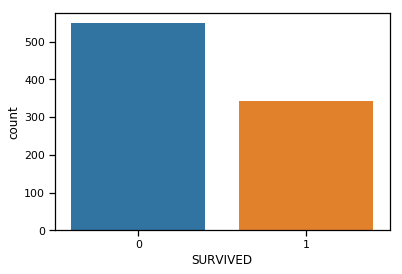

In [3]:
print(df_train_0['SURVIVED'].value_counts(normalize=True))
sns.countplot(x='SURVIVED', data=df_train_0)

Check the missing data.

In [4]:
df_train_0.isnull().sum()

SURVIVED      0
PCLASS        0
NAME          0
SEX           0
AGE         177
SIBSP         0
PARCH         0
TICKET        0
FARE          0
CABIN       687
EMBARKED      2
dtype: int64

Define a new data frame by excluding columns like name and ticket. Recode sex and port of origin. Their cabin location may be correlated (passengers located on the lower decks were lower-class passengers and possibly less likely to have survived), but too many rows in this column are missing (this information is most likely redundantly encoded in the class information). Drop the cabin column. For now, also drop the rows missing the age.

In [14]:
def modify_df(df_0):
    df = df_0.copy()
        
#    #only keep the alphabetical prefix for the cabin information
#    df.loc[:,'DECK'] = df.CABIN.astype(str).apply(lambda x: x[0])
    
    #transform sex, deck, and port of origin information to numerical values
    le = preprocessing.LabelEncoder()
    df['SEX'] = le.fit_transform(df['SEX'])
    print(le.classes_)
    df = pd.concat([df, pd.get_dummies(df['EMBARKED'], prefix_sep='', prefix='EMBARKED')], axis=1)    

    #drop the columns we don't need. name and ticket aren't useful features
    df = df.drop(columns=['CABIN', 'NAME', 'TICKET', 'EMBARKED'])

    #remove the nan rows for now
    df = df.dropna(axis=0)
    
    return df

df_train = modify_df(df_train_0)
df_test = modify_df(df_test_0)
display(df_train.head())

['female' 'male']
['female' 'male']


,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKEDC,EMBARKEDQ,EMBARKEDS
PassengerId,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,0,1
2,1,1,0,38.0,1,0,71.2833,1,0,0
3,1,3,0,26.0,0,0,7.9250,0,0,1
4,1,1,0,35.0,1,0,53.1000,0,0,1
5,0,3,1,35.0,0,0,8.0500,0,0,1


SURVIVED = 0 is associated with a larger value of SEX, which is consistent with what we know: men were less likely to survive than women (M/F encoded to 1/0). Similarly, SURVIVED = 0 is associated with lower passenger fare.

In [15]:
print(df_train.dtypes)
print('*'*80)
print(df_train.groupby('SURVIVED').mean())

SURVIVED       int64
PCLASS         int64
SEX            int64
AGE          float64
SIBSP          int64
PARCH          int64
FARE         float64
EMBARKEDC      uint8
EMBARKEDQ      uint8
EMBARKEDS      uint8
dtype: object
********************************************************************************
            PCLASS       SEX        AGE     SIBSP     PARCH       FARE  \
SURVIVED                                                                 
0         2.485849  0.849057  30.626179  0.525943  0.365566  22.965456   
1         1.872414  0.320690  28.343690  0.493103  0.527586  51.843205   

          EMBARKEDC  EMBARKEDQ  EMBARKEDS  
SURVIVED                                   
0          0.120283   0.047170   0.832547  
1          0.272414   0.027586   0.693103  


Inspect the relationship between the variables. No signs of strong collinearity between the exploratory variables.

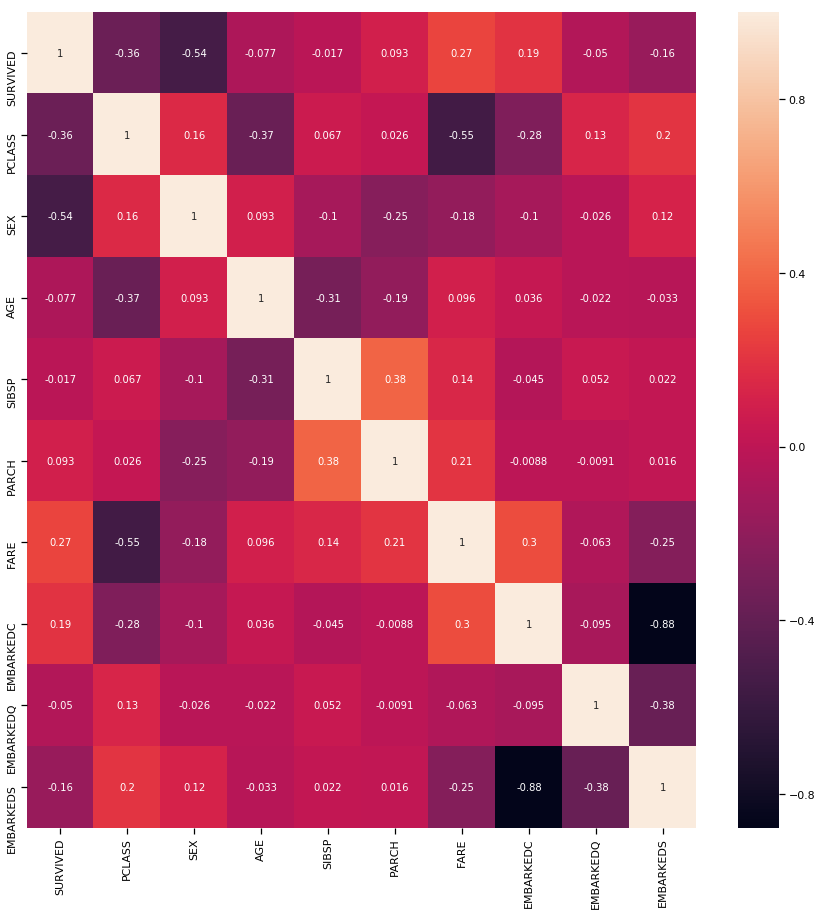

In [16]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr(), annot=True)
#sns.pairplot(df_train)

Standardize the data and use the same transformation for the test set as well.

In [17]:
scaler = preprocessing.StandardScaler().fit(df_train[['AGE', 'FARE']])
df_train_std = df_train.copy()
df_train_std[['AGE', 'FARE']] = scaler.transform(df_train[['AGE', 'FARE']])
df_train_std.head()

df_test_std = df_test.copy()
df_test_std[['AGE', 'FARE']] = scaler.transform(df_test[['AGE', 'FARE']])

In [18]:
y = df_train_std.SURVIVED.values
X = df_train_std.drop(columns='SURVIVED')

X_test = df_test_std

## Time to predict!
### 1. Logistic Regression

Divide the dataset into 5 folds, test 100 regularization parameters, and find the best coeffs and C with the best score obtained by averaging across all folds, then refit over the whole dataset using these parameters.

In [19]:
log_reg = linear_model.LogisticRegressionCV(solver='newton-cg', Cs=np.logspace(-3, 0.3, 20), fit_intercept=True,\
                                            cv=10, penalty='l2', tol=1e-4, refit=True)
clf_lr = log_reg.fit(X, y)
y_pred = clf_lr.predict(X)
print(clf_lr.C_)

[0.05455595]


The coefficient plot confirms our predictions based on knowledge of history. If you were male (sex = 1), lower_class (pclass = high), old (age = high), you were less likely to survive. The table below shows why passengers who left from Chebourg ("C") were more likely to survive: more than half of the passengers who departed from Chebourg traveled in the 1st class.

Text(0, 0.5, 'Coefficients')

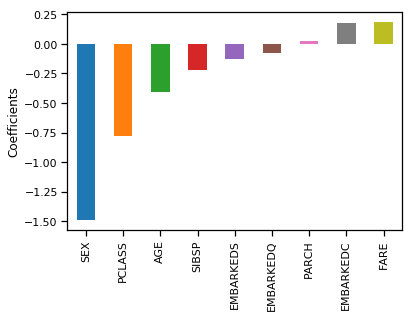

In [20]:
coef = pd.Series(clf_lr.coef_.reshape(-1,), index=X.columns).sort_values()
coef.plot(kind='bar')
plt.ylabel('Coefficients')

In [22]:
pd.crosstab(df_train_0.EMBARKED, df_train_0.PCLASS).apply(lambda x: x/x.sum(), axis=1)

PCLASS,1,2,3
EMBARKED,,,
C,0.505952,0.101190,0.392857
Q,0.025974,0.038961,0.935065
S,0.197205,0.254658,0.548137


Check the accuracy and the confusion matrix.

Accuracy of LR: 0.807


Text(0.5, 12.5, 'Predicted Survival')

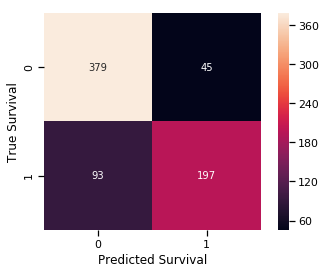

In [23]:
print('Accuracy of LR: {:.3f}'.format(clf_lr.score(X,y)))
cm = metrics.confusion_matrix(y, y_pred)
ax = sns.heatmap(cm, square=True, annot=True, fmt="d")
ax.set_ylabel('True Survival')
ax.set_xlabel('Predicted Survival')

Both scores converge to a value around 0.75-0.8 and the training score is greater than the CV score by just a few percent. This looks pretty good. Adding more data here is unlikely to help much.

In [24]:
train_size, train_score, valid_score = model_selection.learning_curve(\
    linear_model.LogisticRegression(C=clf_lr.C_[0], penalty='l2', tol=1e-4, solver='newton-cg'), X, y, cv=10)

(0.7, 1.0)

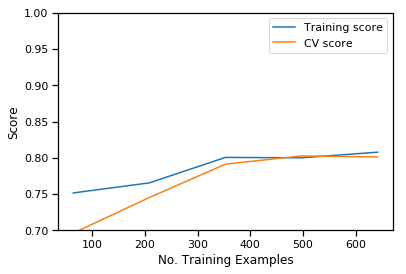

In [25]:
s = sns.lineplot(train_size, np.mean(train_score, axis=1), label='Training score')
s = sns.lineplot(train_size, np.mean(valid_score, axis=1), label='CV score')
s.set_xlabel('No. Training Examples')
s.set_ylabel('Score')
s.set_ylim(0.7, 1.0)

Confirm that the regularization parameter C found above is consistent with the validation curve. C is the inverse regularization strength such that small c is stronger regularization. The chosen C value may be mild overfitting the data.

In [26]:
train_score, valid_score = model_selection.validation_curve(\
    linear_model.LogisticRegression(solver='newton-cg', penalty='l2', tol=1e-4), X, y, "C", np.logspace(-3, 0.3, 20), cv=10)

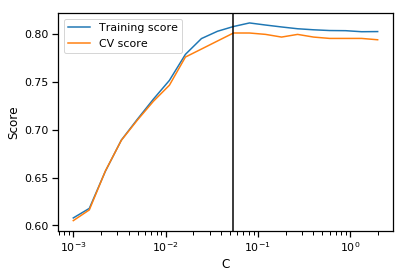

In [27]:
s = sns.lineplot(np.logspace(-3, 0.3, 20), np.mean(train_score, axis=1), label='Training score')
s = sns.lineplot(np.logspace(-3, 0.3, 20), np.mean(valid_score, axis=1), label='CV score')
s.set_xlabel('C')
s.set_ylabel('Score')
s.set_xscale('log')
s.axvline(clf_lr.C_, color='k')

### 2. SVC

There is no built-in Linear SVC with cross validation, so let's do it explicitly. According to the documentation, the implementation is based on libsvm, and in the case of multiclass, it uses the one-vs-one scheme.

Tune the hyperparameters C (regularization), kernel type, and gamma (kernel coefficient).

In [28]:
svc = svm.SVC()
svc_params = {'C': [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0], \
              'kernel': ['linear', 'rbf'], 'gamma': [0.5, 0.2, 0.1, 0.05, 0.001, 0.0001]}

svc_grid = model_selection.GridSearchCV(svc, svc_params, cv=10, scoring='accuracy')
svc_clf = svc_grid.fit(X, y)
y_pred = svc_grid.predict(X)
print('Optimized hyperparameters are: ', svc_clf.best_params_)

Optimized hyperparameters are:  {'C': 4.0, 'gamma': 0.1, 'kernel': 'rbf'}


Accuracy of SVC: 0.828


Text(0.5, 12.5, 'Predicted Survival')

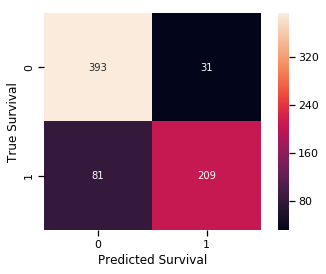

In [29]:
print('Accuracy of SVC: {:.3f}'.format(svc_grid.best_score_))
cm = metrics.confusion_matrix(y, y_pred)
ax = sns.heatmap(cm, square=True, annot=True, fmt="d")
ax.set_ylabel('True Survival')
ax.set_xlabel('Predicted Survival')

The learning curve shows that more examples would be beneficial here. Adding moree data maybe help just a tiny bit.

(0.7, 1.0)

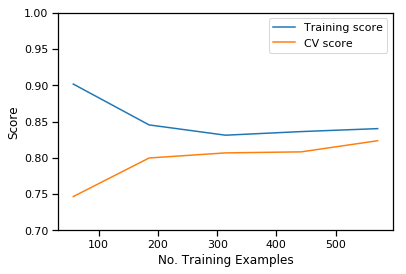

In [30]:
train_size, train_score, valid_score = model_selection.learning_curve(\
    svm.SVC(**svc_grid.best_params_), X, y, cv=5)
s = sns.lineplot(train_size, np.mean(train_score, axis=1), label='Training score')
s = sns.lineplot(train_size, np.mean(valid_score, axis=1), label='CV score')
s.set_xlabel('No. Training Examples')
s.set_ylabel('Score')
s.set_ylim(0.7, 1.0)

Here's a pair of validation curves to test bias/variance. For each hyperparameter $C$ and $\gamma$, hold the other fixed to the best-fit value from the grid search.

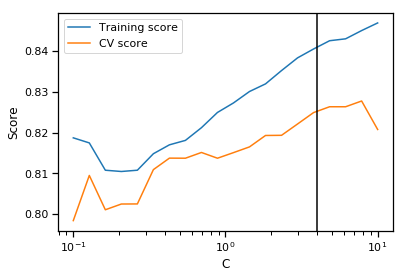

In [36]:
train_score, valid_score = model_selection.validation_curve(\
    svm.SVC(tol=1e-4, gamma=svc_clf.best_params_['gamma']), X, y, 'C', np.logspace(-1, 1, 20), cv=10)
s = sns.lineplot(np.logspace(-1, 1, 20), np.mean(train_score, axis=1), label='Training score')
s = sns.lineplot(np.logspace(-1, 1, 20), np.mean(valid_score, axis=1), label='CV score')
s.set_xlabel('C')
s.set_ylabel('Score')
s.set_xscale('log')
s.axvline(svc_clf.best_params_['C'], color='k')

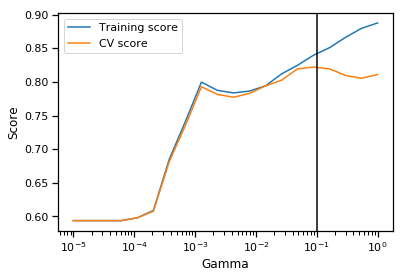

In [42]:
train_score, valid_score = model_selection.validation_curve(\
    svm.SVC(tol=1e-4, C=svc_clf.best_params_['C']), X, y, 'gamma', np.logspace(-5, 0, 20), cv=10)
s = sns.lineplot(np.logspace(-5, 0, 20), np.mean(train_score, axis=1), label='Training score')
s = sns.lineplot(np.logspace(-5, 0, 20), np.mean(valid_score, axis=1), label='CV score')
s.set_xlabel('Gamma')
s.set_ylabel('Score')
s.set_xscale('log')
s.axvline(svc_clf.best_params_['gamma'], color='k')

## Possible future work

1. Additional feature engineering to get higher-order and non-linear terms.